# Binary Model - XGBoost 

Based on the target values and using the test_trial method, we have set a threshold of 10.0 to convert the continuous target into a binary target. Subsequently, we employ the XGBoost Classification algorithm on the input dataset with the binary target. We evaluate the model performance using the Confusion Matrix and Classification Report, Log loss and Classification error plots.

In [1]:
%load_ext jupyter_black

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import shap
import imblearn

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from matplotlib import cm
from mlxtend.plotting import plot_confusion_matrix
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from utils import get_training_dataset

c:\Users\pauni\Desktop\Work\OCHA\GitHub\VirtualEnv\globaltyphoon\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Read csv file and import to df
df = get_training_dataset()
df.head()

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,strong_roof_strong_wall,...,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged,percent_houses_damaged_5years
0,DURIAN,2006,101,0.0,303.180555,0.122917,0.085417,31.000000,NaN,22.580645,...,2.699781,5.762712,3445.709753,1,0.0,0.00,1.00,0.000000,0.0,0.0
1,DURIAN,2006,4475,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,2.639401,...,4.585088,12.799127,8602.645832,1,0.0,0.00,1.00,0.000000,0.0,0.0
2,DURIAN,2006,4639,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,2.639401,...,1.527495,8.833333,5084.012925,1,0.0,0.01,0.99,197.339034,0.0,0.0
3,DURIAN,2006,4640,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,2.639401,...,11.677657,17.530431,55607.865950,1,0.0,0.31,0.69,4970.477311,0.0,0.0
4,DURIAN,2006,4641,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,2.639401,...,17.074011,31.931338,35529.342507,1,0.0,0.77,0.23,12408.594656,0.0,0.0


In [4]:
# Fill NaNs with average estimated value of 'rwi'
df["rwi"].fillna(df["rwi"].mean(), inplace=True)

# Set any values >100% to 100%,
for i in range(len(df)):
    if df.loc[i, "percent_houses_damaged"] > 100:
        df.at[i, "percent_houses_damaged"] = float(100)

In [5]:
# define a threshold to separate target into damaged and not_damaged
thres = 10.0

for i in range(len(df)):
    if df.loc[i, "percent_houses_damaged"] >= thres:
        df.at[i, "binary_damage"] = 1
    else:
        df.at[i, "binary_damage"] = 0

df["binary_damage"] = df["binary_damage"].astype("int")

# Remove previous target 'percent_buildings_damaged' from the dataframe
df = df.drop(["percent_houses_damaged"], axis=1)
df

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,strong_roof_strong_wall,...,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged_5years,binary_damage
0,DURIAN,2006,101,0.0,303.180555,0.122917,0.085417,31.000000,-0.213039,22.580645,...,2.699781,5.762712,3445.709753,1,0.00,0.000000,1.000000,0.000000,0.000000,0
1,DURIAN,2006,4475,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,2.639401,...,4.585088,12.799127,8602.645832,1,0.00,0.000000,1.000000,0.000000,0.000000,0
2,DURIAN,2006,4639,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,2.639401,...,1.527495,8.833333,5084.012925,1,0.00,0.010000,0.990000,197.339034,0.000000,0
3,DURIAN,2006,4640,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,2.639401,...,11.677657,17.530431,55607.865950,1,0.00,0.310000,0.690000,4970.477311,0.000000,0
4,DURIAN,2006,4641,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,2.639401,...,17.074011,31.931338,35529.342507,1,0.00,0.770000,0.230000,12408.594656,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141253,MOLAVE,2020,20677,0.0,644.575831,2.543750,0.778646,4449.357133,0.508167,44.762048,...,18.012771,36.304688,21559.003490,1,0.08,0.080000,0.840000,17619.701390,0.000000,0
141254,MOLAVE,2020,20678,0.0,655.685233,2.558333,0.861458,1521.435795,-0.174100,44.762048,...,13.163042,65.687266,12591.742022,1,0.00,0.420000,0.580000,5623.069564,0.000000,0
141255,MOLAVE,2020,20679,0.0,666.794635,2.975000,0.949479,930.647069,-0.244286,25.078318,...,10.901755,37.414996,19740.596834,1,0.00,0.109091,0.890909,5912.671746,0.015207,0
141256,MOLAVE,2020,20680,0.0,677.904037,2.889583,1.083333,1800.666044,0.038000,16.796996,...,17.917650,105.812452,26363.303778,1,0.03,0.250000,0.720000,11254.164413,0.020806,0


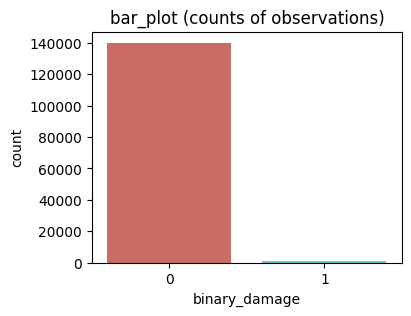

In [6]:
plt.figure(figsize=(4, 3))
sns.countplot(x="binary_damage", data=df, palette="hls")
plt.title("bar_plot (counts of observations)")
plt.show()

In [7]:
# Remove zeros from wind_speed
df = df[(df[["wind_speed"]] != 0).any(axis=1)]
df = df.drop(columns=["grid_point_id", "typhoon_year"])
df.head()

,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,strong_roof_strong_wall,strong_roof_light_wall,strong_roof_salvage_wall,...,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged_5years,binary_damage
138,DURIAN,12.460039,275.018491,0.670833,0.313021,0.479848,-0.213039,31.336503,29.117802,0.042261,...,34.629550,42.218750,5303.659490,1,0.00,0.00,1.00,0.000000,0.0,0
139,DURIAN,11.428974,297.027578,0.929167,0.343229,55.649739,0.206000,23.447758,23.591571,0.037516,...,25.475388,72.283154,61015.543599,1,0.00,0.14,0.86,276.871504,0.0,0
148,DURIAN,13.077471,262.598363,0.716667,0.424479,8.157414,-0.636000,31.336503,29.117802,0.042261,...,54.353996,102.215198,66707.438070,1,0.00,0.11,0.89,448.539453,0.0,0
149,DURIAN,12.511864,273.639330,0.568750,0.336979,88.292015,-0.227500,31.336503,29.117802,0.042261,...,31.814048,58.988877,53841.050168,1,0.00,0.12,0.88,2101.708435,0.0,0
150,DURIAN,11.977511,284.680297,0.589583,0.290625,962.766739,-0.299667,23.546053,23.660429,0.037576,...,25.976413,111.386527,87378.257957,1,0.07,0.46,0.47,11632.726327,0.0,0


array([[<AxesSubplot: title={'center': 'binary_damage'}>]], dtype=object)

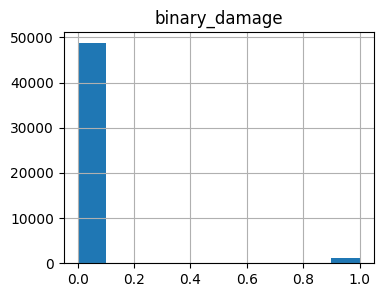

In [8]:
# Show histogram of damage
df.hist(column="binary_damage", figsize=(4, 3))

Text(0.5, 1.0, 'plot after data stratification')

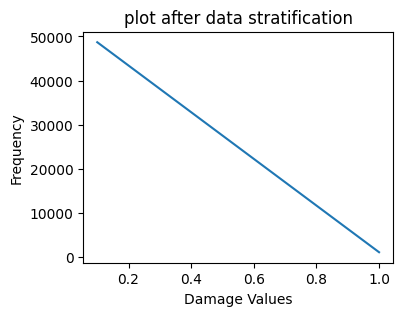

In [9]:
# Hist plot after data stratification
bins2 = [0, 0.1, 1]
samples_per_bin2, binsP2 = np.histogram(df["binary_damage"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)
plt.title("plot after data stratification")

In [10]:
# Check the bins' intervalls (first bin means all zeros, second bin means 0 < values <= 1)
df["binary_damage"].value_counts(bins=binsP2)

(-0.001, 0.1]    48685
(0.1, 1.0]        1069
Name: binary_damage, dtype: int64

In [11]:
print(samples_per_bin2)
print(binsP2)

[48685  1069]
[0.  0.1 1. ]


In [12]:
bin_index2 = np.digitize(df["binary_damage"], bins=binsP2)

In [13]:
y_input_strat = bin_index2

In [14]:
features = [
    "wind_speed",
    "track_distance",
    "total_houses",
    "rainfall_max_6h",
    "rainfall_max_24h",
    "rwi",
    "mean_slope",
    "std_slope",
    "mean_tri",
    "std_tri",
    "mean_elev",
    "coast_length",
    "with_coast",
    "urban",
    "rural",
    "water",
    "total_pop",
    "percent_houses_damaged_5years",
]

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["binary_damage"]

Index(['wind_speed', 'track_distance', 'total_houses', 'rainfall_max_6h',
       'rainfall_max_24h', 'rwi', 'mean_slope', 'std_slope', 'mean_tri',
       'std_tri', 'mean_elev', 'coast_length', 'with_coast', 'urban', 'rural',
       'water', 'total_pop', 'percent_houses_damaged_5years'],
      dtype='object')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, df["binary_damage"], stratify=y_input_strat, test_size=0.2
)

In [16]:
# Check train data before resampling
print(Counter(y_train))

Counter({0: 38948, 1: 855})


In [17]:
# Ask the user whether to perform oversampling or undersampling
sampling_type = int(
    input(
        "Enter 1 for oversampling, 2 for undersampling or 3 for combination of both: "
    )
)

In [18]:
if sampling_type == 1:
    # Define oversampling strategy
    over = RandomOverSampler(sampling_strategy=0.1)
    # Fit and apply the transform
    X_train, y_train = over.fit_resample(X_train, y_train)

elif sampling_type == 2:
    under = RandomUnderSampler(sampling_strategy=0.7)
    X_train, y_train = under.fit_resample(X_train, y_train)

elif sampling_type == 3:
    over = RandomOverSampler(sampling_strategy=0.1)
    X_train, y_train = over.fit_resample(X_train, y_train)

    under = RandomUnderSampler(sampling_strategy=0.7)
    X_train, y_train = under.fit_resample(X_train, y_train)


else:
    print("Invalid input. Please enter 1, 2 or 3.")

In [19]:
# Check train data After resampling
print(Counter(y_train))

Counter({0: 5562, 1: 3894})


In [20]:
# Define a list to keep f1_score of each n_estimator
f1_lst = []
n_estimator_lst = []

In [21]:
# Use XGBClassifier as a Machine Learning model to fit the data
xgb_model = XGBClassifier()

eval_set = [(X_train, y_train), (X_test, y_test)]
# eval_set = [(X_test, y_test)]
xgb_model.fit(
    X_train,
    y_train,
    eval_metric=["error", "logloss"],
    eval_set=eval_set,
    verbose=False,
)

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [22]:
y_pred = xgb_model.predict(X_test)

In [23]:
# y_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[9475,  262],
       [  27,  187]], dtype=int64)

In [24]:
# Classification Report
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      9737
           1       0.42      0.87      0.56       214

    accuracy                           0.97      9951
   macro avg       0.71      0.92      0.77      9951
weighted avg       0.98      0.97      0.98      9951

[[9475  262]
 [  27  187]]


In [25]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.10%


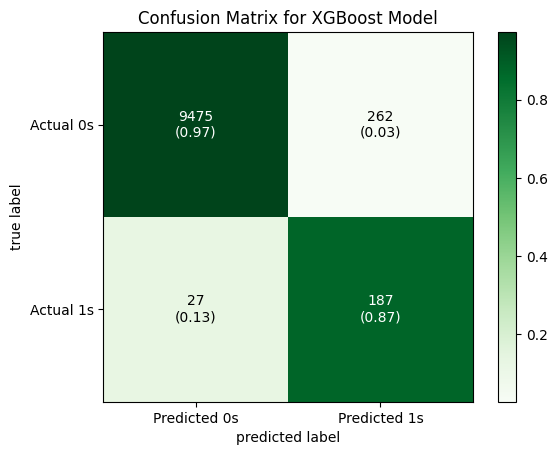

In [26]:
# Plot Confusion Matrix
fig, ax = plot_confusion_matrix(
    conf_mat=cm,
    show_absolute=True,
    show_normed=True,
    colorbar=True,
    cmap=plt.cm.Greens,
)

ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=("Predicted 0s", "Predicted 1s"))
ax.yaxis.set(ticks=(0, 1), ticklabels=("Actual 0s", "Actual 1s"))
plt.title("Confusion Matrix for XGBoost Model")
plt.show()

### Plot Log Loss and Classification Error

In [27]:
results = xgb_model.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

In [28]:
f1_score(y_test, y_pred, average="macro")

0.7745404966674263

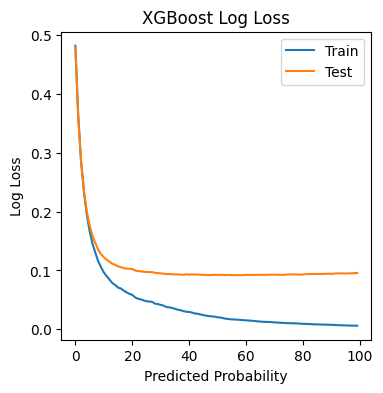

In [29]:
# plot log loss
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()

plt.xlabel("Predicted Probability")
plt.ylabel("Log Loss")
plt.title("XGBoost Log Loss")
plt.show()

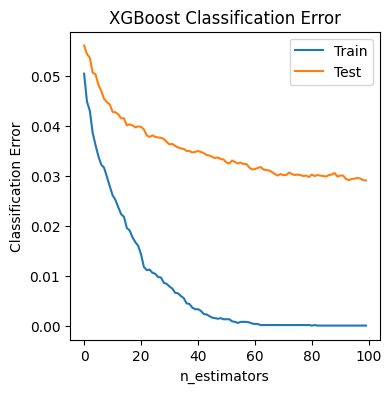

In [30]:
# plot classification error
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()

plt.xlabel("n_estimators")
plt.ylabel("Classification Error")
plt.title("XGBoost Classification Error")
plt.show()

## Feature Importance

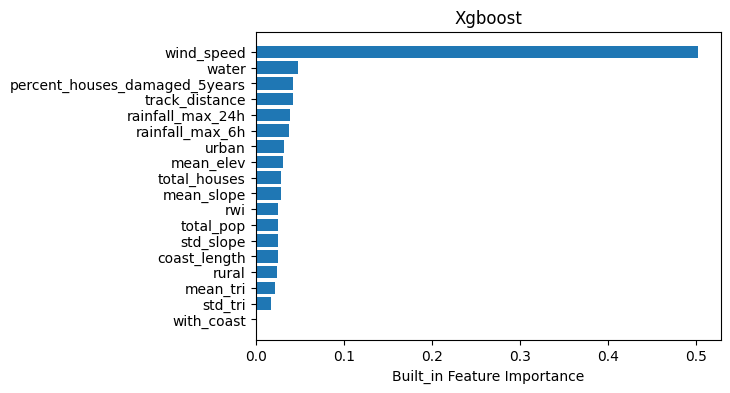

In [31]:
# Xgboost Built-in Feature Importance

# xgb_model.feature_importances_.argsort()[::-1]
plt.rcParams.update({"figure.figsize": (6.0, 4.0)})
plt.rcParams.update({"font.size": 10})

sorted_idx = xgb_model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.xlabel("Built_in Feature Importance")
plt.title("Xgboost")
plt.show()